In [ ]:
import sys
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..')))
# Now you can import the TimeSeriesDataset class
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.utils import download_data, standardize_column, download_data_json, longest_substring_finder

In [47]:
equinox_df = pd.read_excel("../datasets/Equinox2020.05.2023.xlsx", engine='openpyxl')
old_columns = equinox_df.Variable.unique()

In [21]:
polaris_df = pd.concat([pd.read_excel('..\datasets\\Polaris2025.xlsx', sheet_name = "General"),
                        pd.read_excel('..\datasets\\Polaris2025.xlsx', sheet_name = "Social complexity"),
                        pd.read_excel('..\datasets\\Polaris2025.xlsx', sheet_name = "Warfare"),
                        pd.read_excel('..\datasets\\Polaris2025.xlsx', sheet_name = "Luxury goods"),
                        pd.read_excel('..\datasets\\Polaris2025.xlsx', sheet_name = "Religion")])

In [121]:
new_columns = polaris_df.variable_name.unique()
missing_columns = []
col_mappings = {}
for col in new_columns:
    best_match = ''
    best_match_length = 0
    for old_col in old_columns:
    
        match_length = len(longest_substring_finder(col, old_col.replace(" ", "-").lower()))
        if match_length > best_match_length:
            best_match = old_col
            best_match_length = match_length
    
    if (best_match_length/len(col) > 0.5) or (len(best_match) > 10):
        col_mappings[col] = best_match
    else:
        missing_columns.append(col)
        
col_mappings['written-records'] = 'Written records'
col_mappings.pop("polity-religion-genuses")
col_mappings.pop("polity-religion-families")
col_mappings.pop("polity-religions")
col_mappings.pop("polity-alternate-religion-genuses")
col_mappings.pop("polity-alternate-religion-families")
col_mappings.pop("polity-alternate-religions")
col_mappings

{'polity-original-names': 'Original name',
 'polity-alternative-names': 'Alternative names',
 'polity-degree-of-centralizations': 'Degree of centralization',
 'polity-suprapolities': 'Supra-polity relations',
 'polity-utm-timezones': 'Supra-polity relations',
 'polity-capitals': 'Supra-polity relations',
 'polity-linguistic-families': 'Supra-polity relations',
 'polity-relationship-to-preceding-entities': 'relationship to preceding (quasi)polity',
 'polity-preceding-entities': 'relationship to preceding (quasi)polity',
 'polity-succeeding-entities': 'succeeding (quasi)polity',
 'polity-supracultural-entities': 'Supracultural entity',
 'polity-scale-of-supracultural-interactions': 'scale of supra-cultural interaction',
 'polity-religious-traditions': 'Supra-polity relations',
 'polity-territories': 'Polity territory',
 'polity-populations': 'Polity Population',
 'population-of-the-largest-settlements': 'Population of the largest settlement',
 'settlement-hierarchies': 'Settlement hierar

In [122]:
# create an inverse mapping to col_mappings
inverse_col_mappings = {v: k for k, v in col_mappings.items()}
equinox_df["NewVariable"] = equinox_df.Variable.apply(lambda x: inverse_col_mappings[x] if x in inverse_col_mappings else x)

In [123]:
#find new columns that are not in the old columns
missing_columns = []
common_columns = []
for col in equinox_df.NewVariable.unique():
    if col not in new_columns:
        missing_columns.append(col)
    else:
        common_columns.append(col)
print("Missing columns:")
print(common_columns)

Missing columns:
['polity-original-names', 'polity-alternative-names', 'stores-of-wealth', 'polity-religious-traditions', 'trading-emporia', 'polity-preceding-entities', 'polity-succeeding-entities', 'polity-territories', 'settlement-hierarchies', 'administrative-levels', 'religious-fragmentations', 'luxury-fabrics', 'human-sacrifices', 'professional-soldiers', 'professional-priesthoods', 'enclosures', 'examination-systems', 'merit-promotions', 'other-special-purpose-sites', 'formal-legal-codes', 'judges', 'courts', 'professional-lawyers', 'other-measurement-systems', 'luxury-drink-alcohol', 'markets', 'luxury-food', 'roads', 'bridges', 'canals', 'ports', 'nonwritten-records', 'written-records', 'scripts', 'lux-fine-ceramic-wares', 'phonetic-alphabetic-writings', 'luxury-spices-incense-and-dyes', 'calendars', 'sacred-texts', 'religious-literatures', 'practical-literatures', 'histories', 'philosophies', 'fictions', 'articles', 'tokens', 'foreign-coins', 'indigenous-coins', 'paper-curren

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.]),
 [Text(0.0, 0, '0'),
  Text(200.0, 0, '200'),
  Text(400.0, 0, '400'),
  Text(600.0, 0, '600'),
  Text(800.0, 0, '800'),
  Text(1000.0, 0, '1000'),
  Text(1200.0, 0, '1200'),
  Text(1400.0, 0, '1400')])

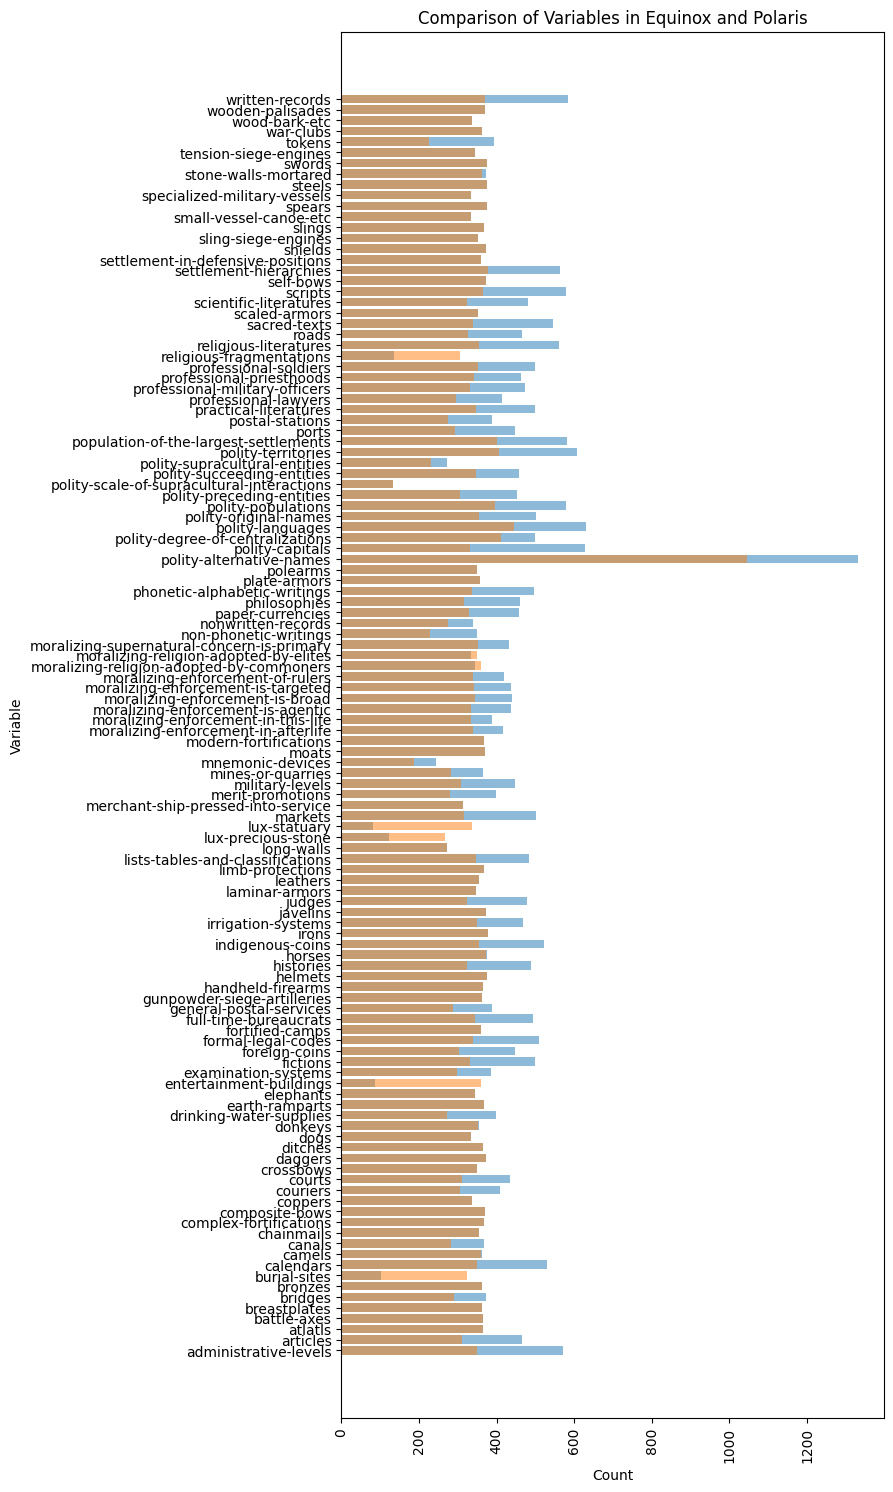

In [56]:
grouped_data_equinox = equinox_df.loc[equinox_df['NewVariable'].isin(common_columns)].groupby('NewVariable').size()
# Group by 'Subsection' and count the occurrences
grouped_data_polaris = polaris_df.loc[polaris_df['variable_name'].isin(common_columns)].groupby('variable_name').size()

# Plot the bar chart
plt.figure(figsize=(7, 18))
plt.barh(grouped_data_polaris.index, grouped_data_polaris.values, label='Polaris', alpha=0.5)
plt.barh(grouped_data_equinox.index, grouped_data_equinox.values, label='Equinox', alpha=0.5)

plt.xlabel('Count')
plt.ylabel('Variable')
plt.title('Comparison of Variables in Equinox and Polaris')
plt.xticks(rotation=90)

In [59]:
print(len(equinox_df.loc[equinox_df['NewVariable'].isin(common_columns)]))
print(len(polaris_df.loc[polaris_df['variable_name'].isin(common_columns)]))
# polaris_df.loc[polaris_df['Subsection'].isin(common_columns)]
polity_df = download_data("https://seshatdata.com/api/core/polities/")
equinox_df["PolityName"] = equinox_df["Polity"].apply(lambda x: polity_df.loc[polity_df["name"] == x, "new_name"].values[0] if x in polity_df["name"].values else None)

40510
48155
Downloaded 839 rows


In [61]:
old_polities = equinox_df.loc[equinox_df['NewVariable'].isin(common_columns), "PolityName"].unique()
new_polities = polaris_df.loc[polaris_df['variable_name'].isin(common_columns), "polity_id"].unique()

#find new polities that are not in the old polities
missing_polities = []
common_polities = []
for col in new_polities:
    if col not in old_polities:
        missing_polities.append(col)
    else:
        common_polities.append(col)

Save Polaris dataset

In [88]:
import requests
from pandas import json_normalize
response = requests.get('https://seshat-db.com/api/', timeout=5)
if response.status_code == 200:
    data = response.json()
    # Normalize the JSON data into a DataFrame
    urls = json_normalize(data)


In [89]:
polity_df = download_data('https://seshat-db.com/api/core/polities/')
polity_df = polity_df[['id','name','long_name','home_seshat_region_name','home_seshat_region_subregions_list',  'start_year', 'end_year']]
polity_df = polity_df.rename(columns={'id':'polity_number','name':'polity_id','home_seshat_region_name': 'seshat_region','home_seshat_region_subregions_list': 'seshat_subregions_list'})
peak_years = download_data('https://seshat-db.com/api/general/polity-peak-years')
polity_df["peak_years_from"] = polity_df.polity_id.apply(lambda x: peak_years.loc[peak_years['polity_name'] == x, "year_from"].values[0] if x in peak_years["polity_name"].values else None)
polity_df["peak_years_to"] = polity_df.polity_id.apply(lambda x: peak_years.loc[peak_years['polity_name'] == x, "year_to"].values[0] if x in peak_years["polity_name"].values else None)

Downloaded 862 rows
Downloaded 302 rows


In [90]:
sql_variables = []

In [91]:
column_names = {"alternative_names": "alternative_name",
                "supra-polity_relations": "supra_polity_relations",
                "polity_capital" : "capital",
                "relationship_to_preceding_(quasi)polity" : "relationship_to_preceding_entity",
                "preceding_(quasi)polity" : "preceding_entity",
                "succeeding_(quasi)polity" : "succeeding_entity",
                "scale_of_supra-cultural_interaction" : "scale"
                }

In [92]:
general_urls = []
for col in urls.columns:
    if col.split("/")[-2] == "general":
        general_urls.append(urls[col].values[0])
general_urls = general_urls[1:]

In [93]:
general_db =pd.DataFrame()
for url in general_urls:
    if url.split('/')[-2] in ["polity-durations", "polity-peak-years"]:
        continue
    var_df = download_data(url)
    if len(var_df) == 0:
        print(f"Empty dataframe for URL: {url}")
        continue
    url_name = url.split('/')[-2]
    var_df = standardize_column(var_df, "name")
    variable_name = var_df.name.iloc[0].lower()
    sql_variables.append(variable_name)
    row_variable_name = variable_name
    if (variable_name not in var_df.columns) and (variable_name + "_from" not in var_df.columns):
        if variable_name in column_names:
            row_variable_name = column_names[variable_name].lower()
        else:
            row_variable_name = "coded_value"
   
    range_var =  row_variable_name + "_from" in var_df.columns
    if range_var:
        new_df = pd.DataFrame({
            "seshat_region": var_df.polity_name.apply(lambda x: polity_df.loc[polity_df['polity_id'] == x, "seshat_region"].values[0] if x in polity_df["polity_id"].values else None),
            "polity_number": var_df['polity_id'],
            "polity_id": var_df['polity_name'],
            "section": url.split('/')[-3],
            "variable_name": url_name,
            "value_from": var_df[row_variable_name + '_from'],
            "value_to": var_df[row_variable_name + '_to'],
            "year_from": var_df['year_from'],
            "year_to": var_df['year_to'],
            "is_disputed": var_df['is_disputed'],
            "is_uncertain": var_df['is_uncertain']
        })
    else:
        new_df = pd.DataFrame({
            "seshat_region": var_df.polity_name.apply(lambda x: polity_df.loc[polity_df['polity_id'] == x, "seshat_region"].values[0] if x in polity_df["polity_id"].values else None),
            "polity_number": var_df['polity_id'],
            "polity_id": var_df['polity_name'],
            "section": url.split('/')[-3],
            "variable_name": url_name,
            "value_from": var_df[row_variable_name],
            "value_to": np.nan,
            "year_from": var_df['year_from'],
            "year_to": var_df['year_to'],
            "is_disputed": var_df['is_disputed'],
            "is_uncertain": var_df['is_uncertain']
        })
    general_db = pd.concat([general_db, new_df], ignore_index=True)

Downloaded 501 rows
Values in 'name' differ. Setting all to most common value: original_name
Downloaded 1331 rows
Values in 'name' differ. Setting all to most common value: alternative_names
Downloaded 499 rows
Values in 'name' differ. Setting all to most common value: degree_of_centralization
Downloaded 382 rows
Values in 'name' differ. Setting all to most common value: supra-polity_relations
Downloaded 500 rows
Values in 'name' differ. Setting all to most common value: utm_zone
Downloaded 629 rows
All values in 'name' are the same. No changes needed.
Downloaded 630 rows
Values in 'name' differ. Setting all to most common value: language
Downloaded 521 rows
Values in 'name' differ. Setting all to most common value: linguistic_family
Downloaded 43 rows
Values in 'name' differ. Setting all to most common value: language_genus
Downloaded 139 rows
Values in 'name' differ. Setting all to most common value: religion_genus
Downloaded 149 rows
Values in 'name' differ. Setting all to most comm

In [94]:
sc_urls = []
for col in urls.columns:
    if col.split("/")[-2] == "sc":
        sc_urls.append(urls[col].values[0])
        
sc_db =pd.DataFrame()
for url in sc_urls:
    var_df = download_data(url)
    if len(var_df) == 0:
        print(f"Empty dataframe for URL: {url}")
        continue
    url_name = url.split('/')[-2]
    variable_name = var_df.name.iloc[0].lower()
    sql_variables.append(variable_name)
    row_variable_name = variable_name
    if (variable_name not in var_df.columns) and (variable_name + "_from" not in var_df.columns):
        row_variable_name = "coded_value"
    range_var =  row_variable_name + "_from" in var_df.columns
    if range_var:
        new_df = pd.DataFrame({
            "seshat_region": var_df.polity_name.apply(lambda x: polity_df.loc[polity_df['polity_id'] == x, "seshat_region"].values[0] if x in polity_df["polity_id"].values else None),
            "polity_number": var_df['polity_id'],
            "polity_id": var_df['polity_name'],
            "section": url.split('/')[-3],
            "variable_name": url_name,
            "value_from": var_df[row_variable_name + '_from'],
            "value_to": var_df[row_variable_name + '_to'],
            "year_from": var_df['year_from'],
            "year_to": var_df['year_to'],
            "is_disputed": var_df['is_disputed'],
            "is_uncertain": var_df['is_uncertain']
        })
    else:
        new_df = pd.DataFrame({
            "seshat_region": var_df.polity_name.apply(lambda x: polity_df.loc[polity_df['polity_id'] == x, "seshat_region"].values[0] if x in polity_df["polity_id"].values else None),
            "polity_number": var_df['polity_id'],
            "polity_id": var_df['polity_name'],
            "section": url.split('/')[-3],
            "variable_name": url_name,
            "value_from": var_df[row_variable_name],
            "value_to": np.nan,
            "year_from": var_df['year_from'],
            "year_to": var_df['year_to'],
            "is_disputed": var_df['is_disputed'],
            "is_uncertain": var_df['is_uncertain']
        })
    sc_db = pd.concat([sc_db, new_df], ignore_index=True)

Empty dataframe for URL: https://seshat-db.com/api/sc/research-assistants/
Downloaded 606 rows
Downloaded 579 rows
Downloaded 582 rows
Downloaded 563 rows
Downloaded 570 rows
Downloaded 446 rows
Downloaded 448 rows
Downloaded 473 rows
Downloaded 500 rows
Downloaded 464 rows
Downloaded 494 rows
Downloaded 385 rows
Downloaded 398 rows
Downloaded 479 rows
Downloaded 509 rows
Downloaded 478 rows
Downloaded 435 rows
Downloaded 414 rows
Downloaded 468 rows
Downloaded 398 rows
Downloaded 501 rows
Downloaded 447 rows
Downloaded 466 rows
Downloaded 373 rows
Downloaded 368 rows
Downloaded 448 rows
Downloaded 366 rows
Downloaded 243 rows
Downloaded 339 rows
Downloaded 584 rows
Downloaded 578 rows
Downloaded 349 rows
Downloaded 496 rows
Downloaded 483 rows
Downloaded 531 rows
Downloaded 546 rows
Downloaded 561 rows
Downloaded 500 rows
Downloaded 489 rows
Downloaded 461 rows
Downloaded 482 rows
Downloaded 499 rows
Downloaded 465 rows
Downloaded 394 rows
Downloaded 398 rows
Downloaded 448 rows
Downl

In [95]:
wf_urls = []
for col in urls.columns:
    if col.split("/")[-2] == "wf":
        wf_urls.append(urls[col].values[0])
        
wf_db =pd.DataFrame()
for url in wf_urls:
    var_df = download_data(url)
    if len(var_df) == 0:
        print(f"Empty dataframe for URL: {url}")
        continue
    url_name = url.split('/')[-2]
    variable_name = var_df.name.iloc[0].lower()
    sql_variables.append(variable_name)
    row_variable_name = variable_name
    if (variable_name not in var_df.columns) and (variable_name + "_from" not in var_df.columns):
        row_variable_name = "coded_value"
    range_var =  row_variable_name + "_from" in var_df.columns
    if range_var:
        new_df = pd.DataFrame({
            "seshat_region": var_df.polity_name.apply(lambda x: polity_df.loc[polity_df['polity_id'] == x, "seshat_region"].values[0] if x in polity_df["polity_id"].values else None),
            "polity_number": var_df['polity_id'],
            "polity_id": var_df['polity_name'],
            "section": url.split('/')[-3],
            "variable_name": url_name,
            "value_from": var_df[row_variable_name + '_from'],
            "value_to": var_df[row_variable_name + '_to'],
            "year_from": var_df['year_from'],
            "year_to": var_df['year_to'],
            "is_disputed": var_df['is_disputed'],
            "is_uncertain": var_df['is_uncertain']
        })
    else:
        new_df = pd.DataFrame({
            "seshat_region": var_df.polity_name.apply(lambda x: polity_df.loc[polity_df['polity_id'] == x, "seshat_region"].values[0] if x in polity_df["polity_id"].values else None),
            "polity_number": var_df['polity_id'],
            "polity_id": var_df['polity_name'],
            "section": url.split('/')[-3],
            "variable_name": url_name,
            "value_from": var_df[row_variable_name],
            "value_to": np.nan,
            "year_from": var_df['year_from'],
            "year_to": var_df['year_to'],
            "is_disputed": var_df['is_disputed'],
            "is_uncertain": var_df['is_uncertain']
        })
    wf_db = pd.concat([wf_db, new_df], ignore_index=True)

Downloaded 273 rows
Downloaded 338 rows
Downloaded 363 rows
Downloaded 378 rows
Downloaded 375 rows
Downloaded 373 rows
Downloaded 365 rows
Downloaded 368 rows
Downloaded 374 rows
Downloaded 369 rows
Downloaded 349 rows
Downloaded 344 rows
Downloaded 353 rows
Downloaded 362 rows
Downloaded 364 rows
Downloaded 362 rows
Downloaded 364 rows
Downloaded 372 rows
Downloaded 375 rows
Downloaded 375 rows
Downloaded 349 rows
Downloaded 333 rows
Downloaded 354 rows
Downloaded 375 rows
Downloaded 362 rows
Downloaded 344 rows
Downloaded 337 rows
Downloaded 354 rows
Downloaded 374 rows
Downloaded 375 rows
Downloaded 362 rows
Downloaded 367 rows
Downloaded 351 rows
Downloaded 347 rows
Downloaded 358 rows
Downloaded 333 rows
Downloaded 314 rows
Downloaded 333 rows
Downloaded 361 rows
Downloaded 369 rows
Downloaded 368 rows
Downloaded 366 rows
Downloaded 370 rows
Downloaded 363 rows
Downloaded 372 rows
Downloaded 360 rows
Downloaded 367 rows
Downloaded 368 rows
Downloaded 354 rows


In [96]:
ec_urls = []
for col in urls.columns:
    if col.split("/")[-2] == "ec":
        ec_urls.append(urls[col].values[0])
        
ec_db =pd.DataFrame()
for url in ec_urls:
    var_df = download_data(url)
    if len(var_df) == 0:
        print(f"Empty dataframe for URL: {url}")
        continue
    url_name = url.split('/')[-2]
    variable_name = var_df.name.iloc[0].lower()
    sql_variables.append(variable_name)
    row_variable_name = variable_name
    if (variable_name not in var_df.columns) and (variable_name + "_from" not in var_df.columns):
        row_variable_name = "coded_value"
    range_var =  row_variable_name + "_from" in var_df.columns
    if range_var:
        new_df = pd.DataFrame({
            "seshat_region": var_df.polity_name.apply(lambda x: polity_df.loc[polity_df['polity_id'] == x, "seshat_region"].values[0] if x in polity_df["polity_id"].values else None),
            "polity_number": var_df['polity_id'],
            "polity_id": var_df['polity_name'],
            "section": url.split('/')[-3],
            "variable_name": url_name,
            "value_from": var_df[row_variable_name + '_from'],
            "value_to": var_df[row_variable_name + '_to'],
            "year_from": var_df['year_from'],
            "year_to": var_df['year_to'],
            "is_disputed": var_df['is_disputed'],
            "is_uncertain": var_df['is_uncertain']
        })
    else:
        new_df = pd.DataFrame({
            "seshat_region": var_df.polity_name.apply(lambda x: polity_df.loc[polity_df['polity_id'] == x, "seshat_region"].values[0] if x in polity_df["polity_id"].values else None),
            "polity_number": var_df['polity_id'],
            "polity_id": var_df['polity_name'],
            "section": url.split('/')[-3],
            "variable_name": url_name,
            "value_from": var_df[row_variable_name],
            "value_to": np.nan,
            "year_from": var_df['year_from'],
            "year_to": var_df['year_to'],
            "is_disputed": var_df['is_disputed'],
            "is_uncertain": var_df['is_uncertain']
        })
    ec_db = pd.concat([ec_db, new_df], ignore_index=True)

Downloaded 162 rows
Downloaded 156 rows
Downloaded 140 rows
Downloaded 117 rows
Downloaded 114 rows
Downloaded 99 rows
Downloaded 110 rows
Downloaded 123 rows
Downloaded 83 rows
Downloaded 103 rows
Downloaded 2 rows


In [97]:
rt_urls = []
for col in urls.columns:
    if col.split("/")[-2] == "rt":

        rt_urls.append(urls[col].values[0])
religion_urls = rt_urls[:3]
msp_urls = rt_urls[4:6] + rt_urls[-12:]

In [98]:
msp_db =pd.DataFrame()
for url in msp_urls:
    var_df = download_data(url)
    if len(var_df) == 0:
        print(f"Empty dataframe for URL: {url}")
        continue
    url_name = url.split('/')[-2]
    variable_name = var_df.name.iloc[0].lower()
    sql_variables.append(variable_name)
    row_variable_name = variable_name
    if (variable_name.lower() + "_name" not in var_df.columns) and (variable_name not in var_df.columns):
        if variable_name in column_names:
            row_variable_name = column_names[variable_name].lower()
        else:
            row_variable_name = "coded_value"
    range_var =  row_variable_name + "_from" in var_df.columns
    if url not in religion_urls:
        new_df = pd.DataFrame({
            "seshat_region": var_df.polity_name.apply(lambda x: polity_df.loc[polity_df['polity_id'] == x, "seshat_region"].values[0] if x in polity_df["polity_id"].values else None),
            "polity_number": var_df['polity_id'],
            "polity_id": var_df['polity_name'],
            "section": url.split('/')[-3],
            "variable_name": url_name,
            "value_from": var_df[row_variable_name],
            "value_to": np.nan,
            "year_from": var_df['year_from'],
            "year_to": var_df['year_to'],
            "is_disputed": var_df['is_disputed'],
            "is_uncertain": var_df['is_uncertain']
        })
    else:
        new_df = pd.DataFrame({
            "seshat_region": var_df.polity_name.apply(lambda x: polity_df.loc[polity_df['polity_id'] == x, "seshat_region"].values[0] if x in polity_df["polity_id"].values else None),
            "polity_number": var_df['polity_id'],
            "polity_id": var_df['polity_name'],
            "section": url.split('/')[-3],
            "variable_name": url_name,
            "value_from": var_df[row_variable_name.lower()+"_religion_name"],
            "value_to": np.nan,
            "year_from": var_df['year_from'],
            "year_to": var_df['year_to'],
            "is_disputed": var_df['is_disputed'],
            "is_uncertain": var_df['is_uncertain']
        })
    msp_db = pd.concat([msp_db, new_df], ignore_index=True)

Downloaded 272 rows
Downloaded 135 rows
Downloaded 440 rows
Downloaded 437 rows
Downloaded 437 rows
Downloaded 443 rows
Downloaded 441 rows
Downloaded 424 rows
Downloaded 339 rows
Downloaded 349 rows
Downloaded 420 rows
Downloaded 391 rows
Downloaded 442 rows
Downloaded 357 rows


In [99]:
pt_df = download_data_json('../datasets/power_transitions.json')
pt_df["seshat_region"] = pt_df.polity_new_ID.apply(lambda x: polity_df.loc[polity_df['polity_id'] == x, "seshat_region"].values[0] if x in polity_df["polity_id"].values else None)
pt_df["polity_number"] = pt_df.polity_new_ID.apply(lambda x: polity_df.loc[polity_df['polity_id'] == x, "polity_number"].values[0] if x in polity_df["polity_id"].values else None)
pt_df["section"] = "crisisdb-pt"
pt_df["variable_name"] = "power-transitions"
pt_df = pt_df[['seshat_region','polity_number','polity_new_ID', 'section', 'variable_name',
       'coded_values_predecessor', 'coded_values_successor',
       'coded_values_contested', 'coded_values_overturn',
       'coded_values_predecessor_assassination', 'coded_values_intra_elite',
       'coded_values_military_revolt', 'coded_values_popular_uprising',
       'coded_values_separatist_rebellion', 'coded_values_external_invasion',
       'coded_values_external_interference', 'year_from', 'year_to', "is_disputed", "is_uncertain" ]]
pt_df.rename(columns={'polity_new_ID': 'polity_id',
                     'coded_values_predecessor': 'predecessor',
                     'coded_values_successor': 'successor',
                     'coded_values_contested': 'contested',
                     'coded_values_overturn': 'overturn',
                     'coded_values_predecessor_assassination': 'predecessor_assassination',
                     'coded_values_intra_elite': 'intra_elite',
                     'coded_values_military_revolt': 'military_revolt',
                     'coded_values_popular_uprising': 'popular_uprising',
                     'coded_values_separatist_rebellion': 'separatist_rebellion',
                     'coded_values_external_invasion': 'external_invasion',
                     'coded_values_external_interference': 'external_interference'
                    }, inplace=True)

In [100]:
crisis_urls = []
for col in urls.columns:

    if col.split("/")[-2] == "crisisdb":
        crisis_urls.append(urls[col].values[0])
crisis_urls = crisis_urls[1:]
crisis_urls

['https://seshat-db.com/api/crisisdb/us-violence-subtypes/',
 'https://seshat-db.com/api/crisisdb/us-violence-data-sources/',
 'https://seshat-db.com/api/crisisdb/us-violences/',
 'https://seshat-db.com/api/crisisdb/crisis-consequences/']

In [101]:
crisis_consequences_db = download_data(crisis_urls[3])
crisis_consequences_db["seshat_region"] = crisis_consequences_db.polity_name.apply(lambda x: polity_df.loc[polity_df['polity_id'] == x, "seshat_region"].values[0] if x in polity_df["polity_id"].values else None)
crisis_consequences_db["polity_number"] = crisis_consequences_db.polity_name.apply(lambda x: polity_df.loc[polity_df['polity_id'] == x, "polity_number"].values[0] if x in polity_df["polity_id"].values else None)
crisis_consequences_db["section"] = "crisisdb-cc"
crisis_consequences_db["variable_name"] = "crisis-consequences"
crisis_consequences_db[['seshat_region','polity_number','polity_name', 'section', 'variable_name', "other_polity_new_name", "other_polity_id",'decline',
       'collapse', 'epidemic', 'downward_mobility', 'extermination',
       'uprising', 'revolution', 'successful_revolution', 'civil_war',
       'century_plus', 'fragmentation', 'capital', 'conquest', 'assassination',
       'depose', 'constitution', 'labor', 'unfree_labor', 'suffrage',
       'public_goods', 'religion',"year_from", "year_to", 'is_disputed', 'is_uncertain']] 
crisis_consequences_db = crisis_consequences_db.rename(
    columns={'polity_name': 'polity_id', 
             'other_polity_new_name': 'other_polity_id',
             'other_polity_id': 'other_polity_number'})

Downloaded 169 rows


In [110]:

new_columns = polaris_df.variable_name.unique()
missing_columns = []
sql_col_mappings = {}
for col in new_columns:
    best_match = ''
    best_match_length = 0
    for sql_col in sql_variables:
    
        match_length = len(longest_substring_finder(col, sql_col.replace(" ", "-").lower()))
        if match_length > best_match_length:
            best_match = sql_col
            best_match_length = match_length
    
    if (best_match_length/len(col) > 0.5) or (len(best_match) > 7):
        sql_col_mappings[col] = best_match
    else:
        missing_columns.append(col)

missing_columns

[]

In [135]:
col_mappings_to_old_names = {
    ## General variables
    "research_assistant": "RA",
    "expert": "Expert",
    "duration": "Duration", #
    "peak_years": "Peak Date", #

    "administrative_level": "AdmLev", # "Administrative levels"
    "article": "Article", # "Articles"
    "atlatl": "Atlatl", # "Atlatl"
    "battle_axe": "BattleAxe", # "Battle axes"
    "breastplate": "Breastplate", # "Breastplates"
    "bridge": "Bridge", # "Bridges"
    "bronze": "Bronze", # "Bronze"
    "calendar": "Calendar", # "Calendar"
    "camel": "Camel", # "Camels"
    "canal": "Canal", # "Canals"
    "chainmail": "Chainmail", # "Chainmail"
    "complex_fortification": "ComplxFort", # "Complex fortifications"
    "composite_bow": "CompBow", # "Composite bow"
    "copper": "Copper", # "Copper"
    "courier": "Courier", # "Couriers"
    "court": "Court", # "Courts"
    "crossbow": "Crossbow", # "Crossbow"
    "dagger": "Dagger", # "Daggers"
    "ditch": "Ditch", # "Ditch"
    "dog": "Dog", # "Dogs"
    "donkey": "Donkey", # "Donkeys"
    "drinking_water_supply_system": "WaterSuppl", # "drinking water supply systems"
    "earth_rampart": "Rampart", # "Earth ramparts"
    "elephant": "Elephant", # "Elephants"
    "examination_system": "ExamSyst", # "Examination system"
    "fiction": "Fiction", # "Fiction"
    "food_storage_site": "FoodStor", # "food storage sites"
    "foreign_coin": "ForCoin", # "Foreign coins"
    "formal_legal_code": "LegCode", # "Formal legal code"
    "fortified_camp": "FortCamp", # "Fortified camps"
    "full_time_bureaucrat": "FullTBur", # "Full-time bureaucrats"
    "general_postal_service": "General postal service",
    "gunpowder_siege_artillery": "Gunpowder siege artillery",
    "handheld_firearm": "HandGun", # "Handheld firearms"
    "helmet": "Helmet", # "Helmets"
    "history": "History", # "History"
    "horse": "Horse", # "Horses"
    "indigenous_coin": "IndigCoin", # "Indigenous coins"
    "iron": "Iron", # "Iron"
    "irrigation_system": "Irrigation", # "irrigation systems"
    "javelin": "Javelin", # "Javelins"
    "judge": "Judge", # "Judges"
    "laminar_armor": "LaminArmor", # "Laminar armor"
    "leather_cloth": "LeathArmor", # "Leather cloth"
    "limb_protection": "LimbProt", # "Limb protection"
    "lists_tables_and_classification": "Lists", # "Lists tables and classifications"
    "long_wall": "LongWall", # "Long walls"
    "market": "Market", # "markets"
    "merchant_ships_pressed_into_service": "Merchant", # "Merchant ships pressed into service"
    "merit_promotion": "MeritProm", # "Merit promotion"
    "military_level": "MilLev", # "Military levels"
    "mines_or_quarry": "Mine", # "Mines or quarries"
    "mnemonic_device": "Mnemonic", # "Mnemonic devices"
    "moat": "Moat", # "Moat"
    "modern_fortification": "ModernFort", # "Modern fortifications"
    "non_phonetic_writing": "NonPhWrit", # "Non-phonetic.alphabetic.writing"
    "nonwritten_record": "NonWRecord", # "Nonwritten records"
    "paper_currency": "PaperCurr", # "Paper currency"
    "philosophy": "Philosophy", # "Philosophy"
    "phonetic_alphabetic_writing": "PhAlph", # "Phonetic alphabetic writing"
    "plate_armor": "PlateArmor", # "Plate armor"
    "polearm": "Polearm", # "Polearms"
    "polity_population": "PolPop", # "Polity Population"
    "polity_territory": "PolTerr", # "Polity territory"
    "population_of_the_largest_settlement": "Population of the largest settlement", # ???
    "port": "Port", # "Ports"
    "postal_station": "PostStation", # "Postal stations"
    "practical_literature": "PractLit", # "Practical literature"
    "precious_metal": "PrecMetal", # "Precious metals"
    "professional_lawyer": "Professional Lawyers",
    "professional_military_officer": "ProfOfficer", # "Professional military officers"
    "professional_priesthood": "ProfPriest", # "Professional priesthood"
    "professional_soldier": "ProfSoldier", # "Professional soldiers"
    "religious_level": "ReligLev", # "Religious levels"
    "religious_literature": "ReligLit", # "Religious literature"
    "road": "Road", # "Roads"
    "sacred_text": "SacrTxt", # "Sacred Texts"
    "scaled_armor": "ScaleArmor", # "Scaled armor"
    "scientific_literature": "SciLit", # "Scientific literature"
    "script": "Script", # "Script"
    "self_bow": "SelfBow", # "Self bow"
    "settlement_hierarchy": "SettlHier", # "Settlement hierarchy"
    "settlements_in_a_defensive_position": "DefPosition", # "Settlements in a defensive position"
    "shield": "Shield", # "Shields"
    "sling_siege_engine": "SlingSiege", # "Sling siege engines"
    "sling": "Sling", # "Slings"
    "small_vessels_canoes_etc": "SmallVessel", # "Small vessels (canoes etc)"
    "spear": "Spear", # "Spears"
    "specialized_government_building": "Specialized government buildings",
    "specialized_military_vessel": "SpecVessel", # "Specialized military vessels"
    "steel": "Steel", # "Steel"
    "stone_walls_mortared": "StoneWall", # "Stone walls (mortared)"
    "stone_walls_non_mortared": "NonMStone", # "Stone walls (non-mortared)"
    "sword": "Sword", # "Swords"
    "tension_siege_engine": "TensSiege", # "Tension siege engines"
    "token": "Token", # "Tokens"
    "war_club": "WarClub", # "War clubs"
    "wood_bark_etc": "WoodArmor", # "Wood bark etc"
    "wooden_palisade": "Palisade", # "Wooden palisades"
    "written_record": "WRecord", # "Written records"
    ## Add these MSP variables, which will be renamed (left-hand side) by Majid when they are added to SQL

}


In [136]:
variables_db = pd.DataFrame(columns=["variable_name", "section", "sheet_name", 'sql_variable_name', "equinox_variable_name","old_variable_name"])
sheet_names = ["General", "Social complexity", "Warfare", "Luxury goods", "Religion", "CrisisDB - Crisis consequences", "CrisisDB - Power transitions"]


for n,df in enumerate([general_db, sc_db, wf_db, ec_db, msp_db, crisis_consequences_db, pt_df]):
    unique_vars = df.variable_name.unique()
    sql_vars = [sql_col_mappings[x] if x in sql_col_mappings else 'not found' for x in unique_vars]
    equinox_variables = [col_mappings[x] if x in col_mappings else 'not found' for x in unique_vars]
    old_vars = [col_mappings_to_old_names[x] if x in col_mappings_to_old_names else 'not found' for x in sql_vars]
    new_df = pd.DataFrame({
        "variable_name": unique_vars,
        "section": df.section.iloc[0],
        "sheet_name": sheet_names[n],
        "sql_variable_name": sql_vars,
        "equinox_variable_name": equinox_variables,
        "old_variable_name": old_vars
    })
    variables_db = pd.concat([variables_db, new_df], ignore_index=True)


In [137]:
variables_db.drop(["section", "sheet_name"], axis=1, inplace=True)
variables_db = variables_db.rename(columns={"variable_name": "api_variable_name"})
variables_db.to_csv("../datasets/variables.csv", index=False)

In [128]:
from openpyxl.utils import get_column_letter

with pd.ExcelWriter('..\datasets\\Polaris2025.xlsx', engine="openpyxl") as writer:

    variables_db.to_excel(writer, sheet_name="Variables", index=False)
    polity_df.to_excel(writer, sheet_name="Polities", index=False)
    general_db.to_excel(writer, sheet_name=sheet_names[0], index=False)
    sc_db.to_excel(writer, sheet_name=sheet_names[1], index=False)
    wf_db.to_excel(writer, sheet_name=sheet_names[2], index=False)
    ec_db.to_excel(writer, sheet_name=sheet_names[3], index=False)
    msp_db.to_excel(writer, sheet_name=sheet_names[4], index=False)
    crisis_consequences_db.to_excel(writer, sheet_name=sheet_names[5], index=False)
    pt_df.to_excel(writer, sheet_name=sheet_names[6], index=False)    

# adjust the column widths
    for sheet_name in writer.sheets:
        worksheet = writer.sheets[sheet_name]
        for col_idx, col_cells in enumerate(worksheet.iter_cols(), start=1):
            max_length = 0
            for cell in col_cells:
                try:
                    if cell.value is not None and len(str(cell.value)) > max_length:
                        max_length = len(str(cell.value))
                except:
                    pass
            adjusted_width = np.clip(10,max_length*0.8 + 0.1,40)
            worksheet.column_dimensions[get_column_letter(col_idx)].width = adjusted_width